In [1]:
## load in the LFP + filtered bandpassed data for each mouse.
# load in the replay times for each mouse 

# plots to make:
# number of spindles REM vs NREM
# spindle rate vs replay
# spindle band power vs replay

In [328]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import get_window
from numpy.fft import fft
import json
from scipy.interpolate import interp1d

##################################

def load_in_sleep_state_scoring(mouse):
    print('---------------------')
    print('searching for sleep state scoring')
    # determine organised data paths for the current mouse
    if mouse.split('_')[0].isdigit():
        org_dat_path = r"Z:\projects\sequence_squad\organised_data\animals\\"
        old_data = True
    else:
        org_dat_path = r"Z:\projects\sequence_squad\revision_data\organised_data\animals\\"
        old_data = False
    org_mouse_file = None
    for file in os.listdir(org_dat_path):
        if mouse.split('_')[0] in file:
            # if the implant = implant
            if mouse.split('_')[1] == file.split('_')[-1][-1]:
                print(f'1. mouse file found: \033[1m{file}\033[0m')
                org_mouse_file = os.path.join(org_dat_path,file)
    mouse_org_data_path = None
    for recording in os.listdir(org_mouse_file):
        if mouse.split('_')[-1] == recording.split('_')[0][-1]:
            print(f'2. recording found: \033[1m{recording}\033[0m')
            mouse_org_data_path = os.path.join(org_mouse_file,recording) + r'\\'

    # load in sleep scoring data 
    sleep_state_score_path = mouse_org_data_path + r"\ephys\LFP\\sleep_state_score\\"
    if not os.path.exists(sleep_state_score_path):
        print(f"Sleep state score files not found for {mouse}.")
    else:
        nrem_start_ends = np.load(sleep_state_score_path + "nrem_start_ends.npy", allow_pickle=True)
        rem_start_ends = np.load(sleep_state_score_path + "rem_start_ends.npy", allow_pickle=True)
        print (f"\033[1mSuccess!\033[0m Loaded sleep state score files for mouse: {mouse}.")
    
    print('----------------------')
        
    return nrem_start_ends,rem_start_ends,mouse_org_data_path,old_data

##################################

def load_in_replay_data(mouse,old_data_bool):
    
    print('---------------------')
    print('searching for replay data')
    if old_data_bool:
        dat_path = r"Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\paper_submission\post_sleep\\"
    else:
        dat_path = ERROR_REPLACE_ME

    for file in os.listdir(dat_path):
        if mouse in file:
            print(f'file found: \033[1m{file}\033[0m')
            pp_path = os.path.join(dat_path,file)
            
    replay_data_path = pp_path + r'\analysis_output\\'

    params_file = pp_path + r'\trainingData\\' + 'params_' + mouse + '.json'
    with open(params_file, 'r') as file:
        params = json.load(file)
    time_spans = params['time_span']
    
    replay_events_df = pd.DataFrame({})
    start_offset = []
    for file in os.listdir(replay_data_path):
        if 'chunk' in file:
            print(file)

            chunk_number = int(file.split('_')[0][-1])

            start_offs = ([0]+list(np.cumsum(np.diff(time_spans))))[chunk_number-1]
            start_offset +=[start_offs]


            print(replay_data_path)

            df_load = pd.read_csv(replay_data_path + file + r'\filtered_replay_clusters_df.csv',index_col=0)
            df_load['chunk'] = [chunk_number]*len(df_load)
            
            df_load['chunk_time'] = [time_spans[chunk_number-1]]*len(df_load)
            fs_times_ephys_time = (df_load.first_spike_time.values - start_offs)
            df_load['first_spike_ephys_time'] = fs_times_ephys_time
            df_load["replay_abs_time"] = df_load['chunk_time'].values[0][0] + df_load["first_spike_ephys_time"] + df_load["event_length"]/2
            replay_events_df = pd.concat((replay_events_df,df_load),axis =0)
            replay_events_df.reset_index(drop = True)

    if mouse == '178_1_7':              
        spikes_file = os.path.join(pp_path,'trainingData\\') + mouse + '.txt'
        neuron_ids, spike_times= [], []
        with open(spikes_file) as f:
            for (i, line) in enumerate(f.readlines()):
                [neuron_id, spike_time] = line.split(' ', 1)
                spike_time = eval(spike_time.split('\n')[0])
                neuron_id = eval(neuron_id.split('\t')[0])
                spike_times.append(spike_time)
                neuron_ids.append(neuron_id)
        spikes_df = pd.DataFrame({'neuron':neuron_ids,'timestamp':spike_times}) 

        print (f"\033[1mSuccess!\033[0m Loaded replay data files for mouse: {mouse}.")
        print('---------------------')
        return replay_events_df,spikes_df
    else:
        print (f"\033[1mSuccess!\033[0m Loaded replay data files for mouse: {mouse}.")
        print('---------------------')
        return replay_events_df
    
##################################

def determine_spectral_power(x, fmin, fmax, fs, window, overlap):
    window_size = int(fs * window)
    step_size = int(fs * (window - overlap))
    
    # Create a Hanning window to reduce spectral leakage
    win_func = get_window("hann", window_size)
    
    delta_spectral_power = []
    timestamps = []
    
    for i in range(0, len(x) - window_size + 1, step_size):
        x_win = x[i:i + window_size] * win_func
        X_win = fft(x_win)
        freqs = np.fft.fftfreq(window_size, d=1/fs)
        
        # One-sided spectrum
        pos_mask = freqs > 0
        freqs = freqs[pos_mask]
        psd = (np.abs(X_win)**2 / (fs * np.sum(win_func**2)))[pos_mask]  # normalized PSD
        
        # Find indices for desired frequency band
        band_mask = (freqs >= fmin) & (freqs <= fmax)
        sp = np.sum(psd[band_mask])
        delta_spectral_power.append(sp)
        
        # Add center timestamp of current window
        timestamps.append((i + window_size / 2) / fs)
    
    return delta_spectral_power,timestamps

def load_sync_file(mouse_org_data_path,mouse):
    current_animals_behav_sync_path = os.path.join(mouse_org_data_path, r"behav_sync\\")
    for stage in os.listdir(current_animals_behav_sync_path):
        if 'post' in stage:
            sync_path = current_animals_behav_sync_path + stage + '\\'
    if mouse == '148_2_2':
        sync_df = pd.read_csv(sync_path + r'Postsleep_Ephys_Camera_sync.csv', encoding='cp1252')
    else:
        sync_df = pd.read_csv(sync_path + r'Postsleep_Ephys_Camera_sync.csv')
        
    return sync_df 

def convolve_movmean(y,N):
    y_padded = np.pad(y, (N//2, N-1-N//2), mode='edge')
    y_smooth = np.convolve(y_padded, np.ones((N,))/N, mode='valid') 
    return y_smooth

def plot_replay_vs_spectral_power(delta_spectral_power,delta_timestamps,replay_events_df,rem_start_ends, nrem_start_ends,var_string):

    spectral_powers = []
    spectral_timestamps = []
    replay_binned = []
    replay_bin_ts = []
    fig,ax= plt.subplots(1, max(replay_events_df.chunk),figsize=(15, 3))
    cumulative_chunk_time = 0
    for i in range(max(replay_events_df.chunk)):
        chunk_dat = replay_events_df[replay_events_df.chunk == i+1]
        chunk_time = chunk_dat.chunk_time[0]  

        R_event_fs_times = (chunk_dat.first_spike_time.values) - cumulative_chunk_time
        
        # bin into 1s bins and take replay rate 
        bin_size = 1
        hist, bins = np.histogram(R_event_fs_times, bins=np.arange(0, np.diff(chunk_time)+bin_size, bin_size))
        
        ## add to cumulative chunk time counter 
        cumulative_chunk_time += np.diff(chunk_time)[0]
        
        chunk_delta_spectral_power = np.array(delta_spectral_power)[(np.array(delta_timestamps) >  chunk_time[0]) * (np.array(delta_timestamps) <  chunk_time[1])]
        chunk_delta_timestamps = delta_timestamps[(np.array(delta_timestamps) >  chunk_time[0]) * (np.array(delta_timestamps) <  chunk_time[1])]

        # Calculate bin centers
        bin_centers = ((bins[:-1] + bins[1:]) / 2) + chunk_time[0]

        ax[i].plot(chunk_delta_timestamps,convolve_movmean(chunk_delta_spectral_power,30), 'blue')
        ax[i].set_xlabel('Time (s)')
        ax[i].set_ylabel(var_string,color = 'blue')
        ax[i].set_title(f'{var_string} vs replay rate')
        ax2 = ax[i].twinx()
        ax2.plot(bin_centers,convolve_movmean(hist,30), color = 'red')
        ax2.set_ylabel('replay rate', color = 'red')
        
        # Add shaded regions without repeating labels
        for ind, (start, end) in enumerate(rem_start_ends):
            label = 'rem' if ind == 0 else None
            ax[i].axvspan(start, end, color='yellow', alpha=0.2, label=label)

        for ind, (start, end) in enumerate(nrem_start_ends):
            label = 'nrem' if ind == 0 else None
            ax[i].axvspan(start, end, color='green', alpha=0.2, label=label)
            
        ax[i].set_xlim(chunk_time[0], chunk_time[1])


        if i == max(replay_events_df.chunk) -1:
            # Move legend off to the right
            ax[i].legend(loc='center left', bbox_to_anchor=(1.1, 0.2))
            
        # set the tight layout
        plt.tight_layout()
        
        # pull out the data for other analysis 
        spectral_powers += [chunk_delta_spectral_power]
        spectral_timestamps += [chunk_delta_timestamps]
        replay_binned += [hist]
        replay_bin_ts += [bin_centers]

    return spectral_powers, spectral_timestamps, replay_binned, replay_bin_ts



In [ ]:
data_path = r"Z:\projects\sequence_squad\revision_data\emmett_revisions\oscillations\striatum_lfp"

for mouse in os.listdir(data_path):
    mouse_data_path = os.path.join(data_path,mouse) + r'\\processed_data\\'
    if not os.path.exists(mouse_data_path):
        print(f"Mouse {mouse} does not have processed data.")
        continue
    print( f'mouse name is: \033[1m{mouse}\033[0m')
    average_lfp = np.load(mouse_data_path + 'average_lfp.npy')
    
    ## load in sleep state scoring data
    nrem_start_ends,rem_start_ends,mouse_org_data_path,old_data_bool = load_in_sleep_state_scoring(mouse)
    
    ## load in replay data, for 178_1_7 i will make some example plots so load in the spikes data also
    if mouse == '178_1_7':
        replay_events_df,spikes_df = load_in_replay_data(mouse,old_data_bool)
    else:
        replay_events_df = load_in_replay_data(mouse,old_data_bool)
        
    # load sync file
    behav_sync_file = load_sync_file(mouse_org_data_path,mouse)
    break



mouse name is: 136_1_3
---------------------
searching for sleep state scoring
1. mouse file found: EJT136_implant1
2. recording found: recording3_11-11-2021
Success! Loaded sleep state score files for mouse: 136_1_3.
----------------------
---------------------
searching for replay data
file found: 136_1_3_run_1007023_2048
chunk1_8700to9300
Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\paper_submission\post_sleep\\136_1_3_run_1007023_2048\analysis_output\\
chunk2_10000to11600
Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\paper_submission\post_sleep\\136_1_3_run_1007023_2048\analysis_output\\
chunk3_11900to12500
Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\paper_submission\post_sleep\\136_1_3_run_1007023_2048\analysis_output\\
Success! Loaded replay data files for mouse: 136_1_3.
---------------------


C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_404\78149583.py:179: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  hist, bins = np.histogram(R_event_fs_times, bins=np.arange(0, np.diff(chunk_time)+bin_size, bin_size))


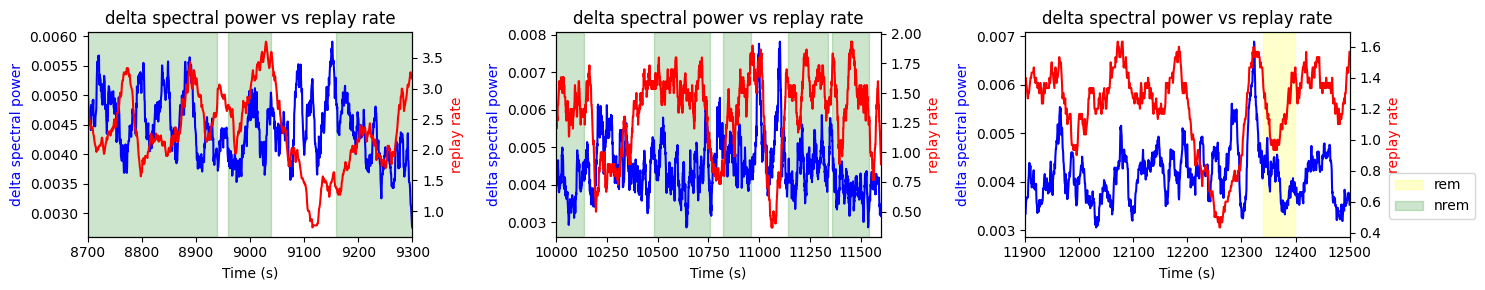

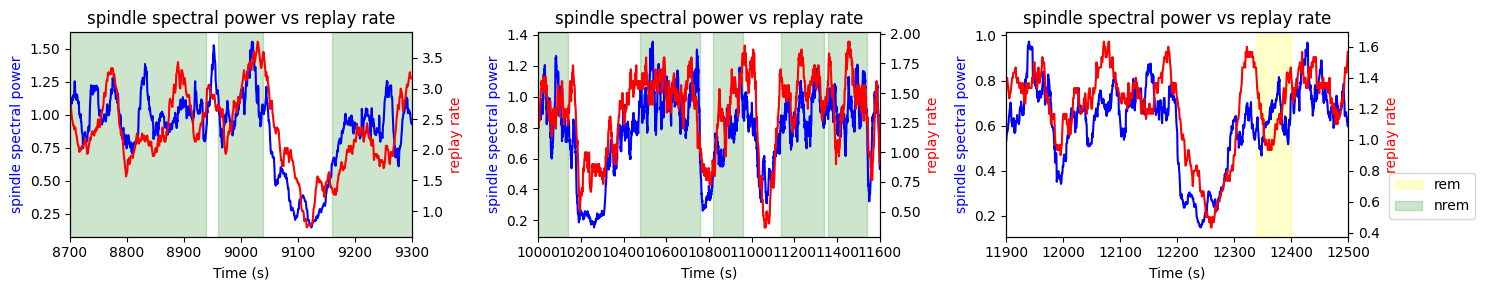

In [360]:
# get the ephys time from the sleep because this is what the lfp was trimmed down to.                        
sleep_period_ephys_start_time = behav_sync_file.Camera_time_Ephys_Aligned[0]

## detemrine delta spectral power 
fmin = 0.5
fmax = 5
fs = 2500
window = 1 # seconds
overlap = 0.5 # seconds
delta_spectral_power,delta_timestamps = determine_spectral_power(average_lfp,fmin,fmax,fs, window,overlap)
delta_timestamps += sleep_period_ephys_start_time

# determine spindle spectral power 
fmin = 9
fmax = 16
fs = 2500
window = 1 # seconds
overlap = 0.5 # seconds
spindle_spectral_power,spindle_timestamps = determine_spectral_power(average_lfp,fmin,fmax,fs, window,overlap)
spindle_timestamps += sleep_period_ephys_start_time

### plot spectral power vs replay rate 
# delta:
delta_spectral_powers, delta_spectral_timestamps, delta_replay_binned, delta_replay_bin_ts = plot_replay_vs_spectral_power(delta_spectral_power,delta_timestamps,replay_events_df,rem_start_ends, nrem_start_ends,'delta spectral power')      
# spindle:
spndl_spectral_powers, spndl_spectral_timestamps, spndl_replay_binned, spndl_replay_bin_ts = plot_replay_vs_spectral_power(spindle_spectral_power,spindle_timestamps,replay_events_df,rem_start_ends, nrem_start_ends,'spindle spectral power')    


# Interpolate data1 values to match data2 timestamps (they have different sample/binning frequencies and are misalined in their binning)
# i need to do this alignment in order to correlate them
# delta
replay_aligned_delta_spectral_powers = []
for i in range(len(delta_spectral_timestamps)):
    interp_func = interp1d(delta_spectral_timestamps[i], delta_spectral_powers[i], kind='linear', fill_value='extrapolate')
    _interp = interp_func(delta_replay_bin_ts[i])
    replay_aligned_delta_spectral_powers += [_interp]
# spindle
replay_aligned_spndl_spectral_powers = []
for i in range(len(spndl_spectral_timestamps)):
    interp_func = interp1d(spndl_spectral_timestamps[i], spndl_spectral_powers[i], kind='linear', fill_value='extrapolate')
    _interp = interp_func(spndl_replay_bin_ts[i])
    replay_aligned_spndl_spectral_powers += [_interp]


## plot cross correlation or something (ask chatgpt...)


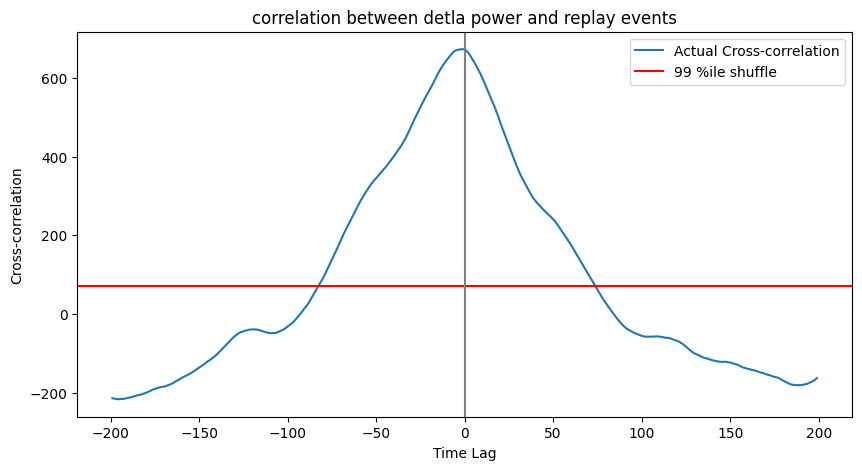

In [386]:
from scipy.stats import zscore


def calculate_cross_correlation(replay_aligned_spndl_spectral_powers, spndl_replay_binned, smoothing_window,num_shuffles=1000):

    chunk_cross_corr_actual = []
    chunk_percentle = []
    for i in range(len(spndl_replay_binned)):
        
        # Replace signal1 and signal2 with your actual time-varying data
        signal1 = zscore(convolve_movmean(replay_aligned_spndl_spectral_powers[i], smoothing_window))
        signal2 = zscore(convolve_movmean(spndl_replay_binned[i],smoothing_window))

        # Calculate the cross-correlation using the z-scored signals (as before)
        cross_corr_actual = np.correlate(signal1, signal2, mode='full')

        # Initialize an array to store shuffled cross-correlation values
        max_shuffle = []
        # Perform shuffling and calculate cross-correlation for each iteration
        for i in range(num_shuffles):
            # Shuffle one of the signals (you can choose which one to shuffle)
            shuffled_signal1 = np.random.permutation(signal1)
            # Calculate the cross-correlation with the shuffled signal
            max_shuffle += list(np.correlate(shuffled_signal1, signal2))

        time_lags = np.arange(-len(signal1) + 1, len(signal1))
        chunk_cross_corr_actual += [list(cross_corr_actual[(time_lags > - 200) * (time_lags < 200)])]
        chunk_percentle += [np.percentile(max_shuffle,99)]
        
    return chunk_cross_corr_actual, chunk_percentle

# delta


# spindle
smoothing_window = 20  # over a 20 second window 
chunk_cross_corr_actual,chunk_percentle = calculate_cross_correlation(replay_aligned_spndl_spectral_powers, spndl_replay_binned, smoothing_window,num_shuffles=1000)


fig,ax= plt.subplots(1, 1,figsize=(10, 5))
# Plot the cross-correlation result
time_lags = np.arange(-200 + 1, 200)
ax.plot(time_lags, np.mean(chunk_cross_corr_actual,axis = 0), label='Actual Cross-correlation')
ax.axhline(np.mean(chunk_percentle) ,color = 'red', label= '99 %ile shuffle')
ax.axvline(0,color = 'grey')
ax.set_xlabel('Time Lag')
ax.set_ylabel('Cross-correlation')
ax.set_title('correlation between detla power and replay events')
ax.legend()

# z score the averages to normalise and save out for future across animals anlaysis

In [363]:
from scipy.stats import pearsonr

for i in range(len(delta_replay_binned)):
    corr, pval = pearsonr(delta_replay_binned[i], replay_aligned_delta_spectral_powers[i])

    
print(corr, pval)

-0.028180779012128364 0.49083418140907953


In [308]:
## simple pearson coefficent for each vs shuffle

## do this for various timescales / smoothenings 

## Cross-Correlation / Lag Analysis
  
# maybe plot the Coherence (Frequency Domain Relationship)... maybe 

In [ ]:
# for each mouse find the spindles

# average spindle during replay rem vs nrem 

# for spindles linked to a replay (1.5s..), do they occur before or after it? 
